# Neural Networks and Deep Learning - Programming Assignment

## Import libraries

In [ ]:
! pip3 install torch torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 80.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.4 MB/s eta 0:00:00


In [ ]:
import torch
from torch import nn, utils
import numpy as np
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

torch.manual_seed(42)

## DataLoader

In [ ]:
"""
Load data using torch DataLoader class.
Batch size = 32
"""

train = CIFAR10(
    "/content/drive/MyDrive/ai-msc",
    train = True,
    #download = True,
    transform = transforms.ToTensor()
    )

test = CIFAR10(
    "/content/drive/MyDrive/ai-msc",
    #download = True,
    train = False,
    transform = transforms.ToTensor()
    )

batch = 32
train_dl = utils.data.DataLoader(
    train,
    batch,
    shuffle = True
    )
test_dl = utils.data.DataLoader(
    test,
    batch
    )

## Basic Architecture

In [ ]:
def weights_init(net):
    """
    Init layer parameters.

    Convolutional layers:
      Xavier Normal
      Bias = 0
    Linear Layers:
      Normal distribution with 0.001 standard deviation
      Bias = 0
    """
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_normal_(m.weight)
            if m.bias.any():
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, std=1e-3)
            if m.bias.any():
                nn.init.constant_(m.bias, 0)

In [ ]:
class IntermediateBlock(nn.Module):

  """
  Class for the intermediate convolutional layer with architecture specifed by
  assignment.
  """

  def __init__(
      self,
      input_channels = 3,
      output_channels = 32,
      output_volume = 32,
      units = 6,
      ):
    """
    input_channels:
      The number of channels for incoming image
    output_channels:
      The number of channels for outgoing image
    output_volume:
      The size of the output image
    units:
      The number of convolutional units within the block
    """

    super(IntermediateBlock, self).__init__()

    self.units = units

    # Set up the feed-forward network with the same number of outputs as units
    # for weighting each convolutional unit within block
    self.fc = nn.Sequential(
        nn.Linear(input_channels, 32),
        nn.LeakyReLU(),
        nn.Linear(32, self.units),
        nn.Softmax(dim = 1)
    )

    # Each convolutional unit applies LeakyReLU activation function to outputs
    # Adaptive Average Pooling is used to ensure output dimensionality is
    # consistent
    self.conv_layer = nn.ModuleList([
      nn.Sequential(
        nn.Conv2d(
            input_channels,
            output_channels,
            kernel_size = 8,
            stride = 1,
            padding = "same"
            ),
        nn.LeakyReLU(),
        nn.AdaptiveAvgPool2d(output_volume)
      )
    ] * units)

  def forward(self, x):

    # Calculate the mean of input x and pass it through a feed forward network
    # This returns weights specifying which convolutional units to weigh more
    m = torch.mean(x, dim = [2, 3])
    a = self.fc(m)

    # Calculate the output of each convolutional layer and multiply it by
    # the corresponding coefficient generated by the feed forward network above
    # Stack and sum outputs of each convolutional layer
    conv_layer_out = []

    for coef, unit in zip(a.T, self.conv_layer):
      conv_out = unit(x)
      coef = coef.reshape(-1,1,1,1)
      conv_layer_out.append(torch.mul(coef, conv_out))

    return torch.sum(torch.stack(conv_layer_out,dim = 0), dim = 0)

In [ ]:
class OutputBlock(nn.Module):

  """
  Class for the output bloc with architecture specifed by assignment.
  """

  def __init__(self, input_channels, input_volume):

    super(OutputBlock, self).__init__()

    self.input_channels = input_channels
    self.input_volume = input_volume

    # Calculate size of flattened image for input layer to feed forward network
    self.first_layer_inputs = (input_volume * input_volume * input_channels)

    # Set up feed forward network with LeakyReLU activation
    self.fc = nn.Sequential(
      nn.Flatten(),
      nn.Linear(self.first_layer_inputs, 32),
      nn.LeakyReLU(),
      nn.Linear(32, 10),
      nn.LeakyReLU()
      )

  def forward(self, x):

    # Calculate logits from feed forward network
    logits = self.fc(x)

    return logits


In [ ]:
class BasicNN(nn.Module):

  """
  Class defining basic neural network architecture based on that specified in
  assignment
  """

  def __init__(self, block_config):

      """
      block_config:
        Dictionary containing the configuration for each intermediate block
      """
      super(BasicNN, self).__init__()

      # Set up empty sequential container to iteratively add blocks based on
      # config dictionary
      self.spine = nn.Sequential()

      # Iterate through config dictionary and add each block to spine
      for i, block in enumerate(block_config.values()):

        self.spine.append(IntermediateBlock(**block))

      # Add output block to spine
      self.spine.append(OutputBlock(32, 24))

  def forward(self, x):

    return self.spine(x)


In [ ]:
block_config = {
    # Input volume 32
    "block_1": {
        "input_channels": 3,
        "output_channels": 32,
        "output_volume": 28,
        "units": 6
    },
    # Input volume: 28
    "block_2": {
        "input_channels": 32,
        "output_channels": 32,
        "output_volume": 28,
        "units": 6
    },
    # Input volume: 28
    "block_3": {
        "input_channels": 32,
        "output_channels": 32,
        "output_volume": 26,
        "units": 6
    },
    # Input volume: 26
    "block_4": {
        "input_channels": 32,
        "output_channels": 32,
        "output_volume": 26,
        "units": 6
    },
    # Input volume 24
    "block_5": {
        "input_channels": 32,
        "output_channels": 32,
        "output_volume": 24,
        "units": 6
    },
}

## Training and testing

In [ ]:
def accuracy(model, dataloader, return_loss = False):
  """
  Calculates the accuracy of an image classifier.

  model:
    Classification model
  Dataloader:
    Generates each batch of the dataset
  return_loss:
    Flag to return the cumulative loss on the dataset
  """

  # Initialise variables to track total samples and correct predictions
  # Initialise softmax layer
  total, correct = 0, 0
  m = nn.Softmax(dim = 1)

  # Initialise loss function and loss variable
  loss = 0
  loss_function = nn.CrossEntropyLoss().to(device)

  # Set model to evaluation mode to prevent gradient tracking for these
  # calculations
  model.eval()

  # Iterate through each batch in dataloader
  for data in dataloader:

    # Get model outputs from inputs
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)

    # Generate predictions by applying softmax and taking max argument
    pred = torch.argmax(m(outputs.data), 1)

    # Add batch size to total
    total += labels.size(0)

    # Add number of correct predictions to correct
    correct += (pred == labels).sum().item()

    # If return_loss add loss
    if return_loss:
      loss += loss_function(outputs, labels).item()

  # Return accuracy and loss (zero if return_loss set to False)
  return correct/total, loss



In [ ]:
# Borrowed from: https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch

class EarlyStopper:

    """
    Class to track changes in validation loss
    """

    def __init__(self, patience=1, min_delta=0):
        """
        patience:
          Number of epochs to wait before returning true after no change in
          loss greater than minimum delta
        min_delta:
          The minimum change required the prevent early stoppage
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')


    def early_stop(self, validation_loss):
        """
        Method calculates if training should stop early based on validation loss
        changes
        """

        # If incoming validation loss is larger than the minimum seen validation
        # loss minus the minimum delta
        if validation_loss > (self.min_validation_loss - self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True

        # Otherwise set minimum validation loss to new validation loss
        else:
          self.counter = 0
          self.min_validation_loss = validation_loss

        return False

In [ ]:
def train_network(net):
  """
  Function for training neural network on CIFAR 10.

  Returns train accuracy, test accuracy and training loss per epoch.

  Generate plot of training accuracy, test acuracy and training loss per epoch.
  """

  # Use cross-entropy loss
  loss_fn = nn.CrossEntropyLoss()
  loss_fn.to(device)

  # Use Adam optimisation for weight updates
  optimizer = torch.optim.Adam(net.parameters(), lr = alpha)

  # Use cosine annealing to adjust the learning rate for each epoch
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, max_epochs)

  # Enable gradient scaling to calculate weight updates where gradients are
  # small
  scaler = torch.cuda.amp.GradScaler(enabled=True)

  losses = []
  train_accuracy = []
  test_accuracy = []

  # Initialise early stopper
  stopper = EarlyStopper(patience = 5, min_delta = 1)

  # Iterate through each epoch
  for j, epoch in tqdm(enumerate(range(max_epochs))):

    # Initialise loss for epoch to zero
    loss_epoch = 0

    # Start iterating through batches
    for i, data in enumerate(train_dl, 0):

      # Put model in train mode to calculate gradients
      net.train()

      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      # Context manager enabling automatic mixed precision for forward pass
      # and loss calculation.
      with torch.cuda.amp.autocast(enabled=True):
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)

      # Calculate backward pass and update weights using gradient scaler
      scaler.scale(loss).backward()
      scaler.step(optimizer)
      scaler.update()

      # Zero the optimizer gradient
      optimizer.zero_grad()

      # Add loss per batch to epoch loss
      loss_epoch += loss.item()

    # Collect model performance statistics for epoch
    losses.append(loss_epoch)
    train_accuracy.append(accuracy(net, train_dl)[0])
    test_acc_epoch, test_loss = accuracy(net, test_dl, return_loss = True)
    test_accuracy.append(test_acc_epoch)

    # Check change in validation loss
    if stopper.early_stop(test_loss):
      break

    # Print training statistics for first five epochs and then every third
    if (j < 5) or (j % 3 == 0):
      print()
      print(train_accuracy[-1])
      print(test_accuracy[-1])
      print(losses[-1])

  # Print final statistics once training is complete
  print(f"""
    Final statistics:
      Training Accuracy: {train_accuracy[-1]}
      Test Accuracy: {test_accuracy[-1]}
      Loss: {losses[-1]}
  """)

  # Plot training accuracy, test accuracy and loss per epoch
  fig, ax = plt.subplots(nrows = 2, figsize = (8, 8))

  ax[0].plot(range(len(train_accuracy)), train_accuracy, label = "Training")
  ax[0].plot(range(len(test_accuracy)), test_accuracy, label = "Test")

  ax[1].plot(range(len(losses)), losses)

  ax[0].legend()

  plt.show();

  return train_accuracy, test_accuracy, losses

0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1040.)
  return F.conv2d(input, weight, bias, self.stride,
1it [01:11, 71.75s/it]


0.42304
0.4267
2879.616572856903


2it [02:23, 71.75s/it]


0.50252
0.4937
2310.8733234405518


3it [03:34, 71.46s/it]


0.55316
0.5375
2090.0225071907043


4it [04:45, 71.33s/it]


0.58556
0.5686
1934.6986529231071


5it [05:57, 71.37s/it]


0.61496
0.5863
1805.5262751579285


7it [08:19, 71.28s/it]


0.65196
0.6078
1614.7197657227516


10it [11:51, 70.88s/it]


0.70622
0.6429
1386.2828766703606


13it [15:23, 70.68s/it]


0.75176
0.6709
1198.7196207046509


16it [18:55, 70.58s/it]


0.7734
0.6707
1054.249535113573


19it [22:26, 70.40s/it]


0.8161
0.6766
921.0135945677757


19it [23:36, 74.57s/it]



    Final statistics:
      Training Accuracy: 0.81398
      Test Accuracy: 0.682
      Loss: 875.3243458867073
  


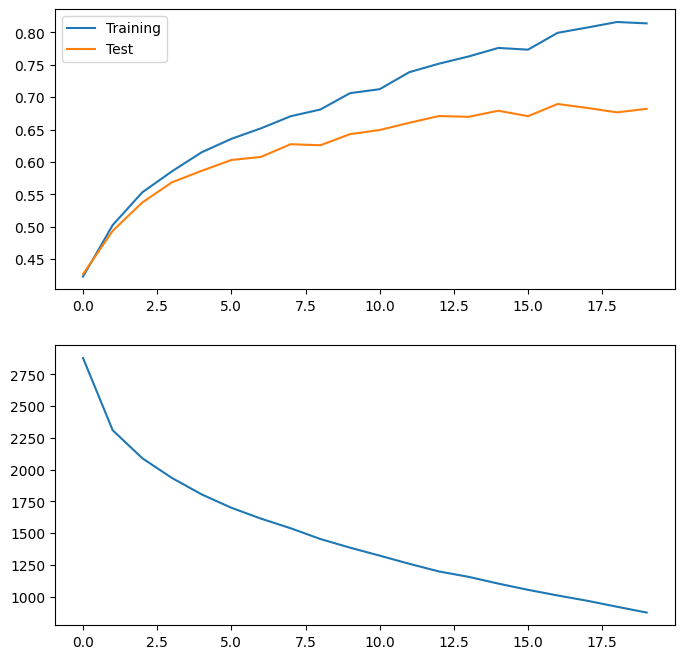

In [ ]:
# Set training parameters
device = torch.device("cuda")
max_epochs = 30
alpha = 0.0001

# Initialise basic neural net; parameters
basic_net = BasicNN(block_config).to(device)
basic_net.apply(weights_init)

# Train basic NN
basic_train_accuracy, basic_test_accuracy, basic_losses = train_network(basic_net)